In [1]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from tqdm import tqdm
import pickle
import seaborn as sns

sns.set(style="ticks", context="talk", color_codes=True)
# font = {'family': 'normal',
#         'weight': 'bold',
#         'size': 22}

# matplotlib.rc('font', **font)

from astropy.io import fits
from astropy.table import Table
from astropy import units as u
from astropy.io import ascii
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

from dustmaps.bayestar import BayestarWebQuery
from whampy.skySurvey import SkySurvey

from astro import distance
from lvmsurveysim.utils import shadow_height_lib as sh
from lvmdrp.core import sky


from skyfield.api import load
from skyfield.framelib import ecliptic_frame
from skyfield.positionlib import ICRS
from skyfield.api import Star
from skyfield.almanac import risings_and_settings


def moon_phase(jd, ephemeris):
    """Returns lunation for a given ephemeris and JD
    
    NOTES: original source from https://bit.ly/3VppeZo
    """

    ts = load.timescale()
    t = ts.tt_jd(jd)

    sun, moon, earth = ephemeris['sun'], ephemeris['moon'], ephemeris['earth']

    e = earth.at(t)
    s = e.observe(sun).apparent()
    m = e.observe(moon).apparent()

    _, slon, _ = s.frame_latlon(ecliptic_frame)
    _, mlon, _ = m.frame_latlon(ecliptic_frame)
    phase = (mlon.degrees - slon.degrees) % 360.0

    return m.fraction_illuminated(sun)


def moon_separation(jd, ephemeris, ra, dec):
    """Returns moon separation from given target"""
    
    e = ephemeris["earth"].at(load.timescale().tt_jd(jd))

    dk = ICRS.from_radec(ra, dec)

    om = e.observe(ephemeris["moon"])
    ra, dec, _ = om.radec()
    sep = dk.separation_from(ICRS.from_radec(ra_hours=ra.hours, dec_degrees=dec.degrees)).degrees

    return sep

In [2]:
# read dark patches table
darks = ascii.read('_data-sky/darks.txt')

new_darks = ascii.read("_data-sky/sky_field_IRDCS_dobashi2011.txt")

new_darks.rename_columns(
    names=["ID_Dobashi2011", "ra(J2000)", "dec(J2000)", "IMW80_WHAM(Rayleighs)", "IMW40_WHAM(Rayleighs)"],
    new_names=["ID", "ra", "dec", "IMW80", "IMW40"]
)

for dark in darks:
    new_darks.add_row([np.nan, dark["ra"], dark["dec"], dark["IMW80"], dark["IMW40"], np.nan])

new_darks.sort(keys="ra")

new_darks["i"] = np.arange(len(new_darks))
new_darks.info()

<Table length=1149>
          name           dtype  n_bad
----------------------- ------- -----
                     ID float64   675
                     ra float64     0
                    dec float64     0
                  IMW80 float64     0
                  IMW40 float64     0
n_fibers_bright_in_gaia float64   675
                      i   int64     0


In [3]:
# read survey tables
lvm = ascii.read('_data-sky/survey.txt')
lvm = lvm[lvm['ra']!=-999.0]

lvm.add_column(np.arange(len(lvm), dtype=int), name="i")
lvm.add_column(np.arctan(lvm["lunation"])*180/np.pi, name="moon_sun_sep")

TARGET_SURVEY = "FULLSKY"
survey = lvm[lvm["target"] == TARGET_SURVEY]
survey


JD,observatory,target,group,tileid,index,ra,dec,pa,airmass,lunation,shadow_height,moon_dist,lst,exptime,totaltime,i,moon_sun_sep
float64,str3,str12,str6,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64
2459948.805059729,LCO,FULLSKY,ALLSKY,1024739,1968,129.43820224719101,-5.056179775280882,0.0,1.1230315971337637,0.9314728552535911,1017.4520707911919,64.10752178656843,9.517918542120606,900.0,990.0000000000001,44,42.96804290613094
2459948.8165180623,LCO,FULLSKY,ALLSKY,1023968,1197,138.13953488372093,15.1685393258427,0.0,1.4136401088976378,0.9314728552535911,1015.5793299592212,63.145910661692916,9.793671461970856,900.0,990.0000000000001,45,42.96804290613094
2459949.8051448795,LCO,FULLSKY,ALLSKY,1024516,1745,141.57303370786516,1.011235955056186,0.0,1.1557399289659196,0.9712185433583314,1003.5608431512785,60.58636348513556,9.585677570321907,900.0,990.0000000000001,65,44.16349263765874
2459950.804167936,LCO,FULLSKY,ALLSKY,1023974,1203,163.2558139534884,15.1685393258427,0.0,1.4880082457030084,0.9934526605258615,1005.5890040932535,61.54968812186149,9.627876558123777,900.0,990.0000000000001,84,44.81181716655173
2459951.5979621634,LCO,FULLSKY,ALLSKY,1025556,2785,133.84615384615384,-29.325842696629206,0.0,1.7091921894514037,0.9978511724445136,1013.7359791645517,60.12595675490734,4.731098092564692,900.0,990.0000000000001,85,44.938374437469456
2459951.8042121595,LCO,FULLSKY,ALLSKY,1025551,2780,87.6923076923077,-29.325842696629206,0.0,1.5513166262968223,0.9978511724445136,1010.4672780352439,60.39029730700139,9.694650649713973,900.0,990.0000000000001,103,44.938374437469456
2459953.8073639222,LCO,FULLSKY,ALLSKY,1025432,2661,97.77777777777777,-25.280898876404503,0.0,1.4136020345692777,0.9541877909433125,1037.1324471653768,60.32120685084244,9.90191970669354,900.0,990.0000000000001,125,43.657055608163915
2459962.8345956104,LCO,FULLSKY,ALLSKY,1024359,1588,133.48314606741573,5.056179775280903,0.0,1.46700213389715,0.1872842849831461,1009.0105925320827,110.86407109550203,11.148658031411468,900.0,990.0000000000001,257,10.607715008386648
2459963.8343955865,LCO,FULLSKY,ALLSKY,1024437,1666,133.48314606741573,3.0337078651685503,0.0,1.4435899104977301,0.10535488124849113,1012.978195147929,123.56441141408772,11.20955413930739,900.0,990.0000000000001,265,6.014203675900861


Text(0, 0.5, 'EBV (mag)')

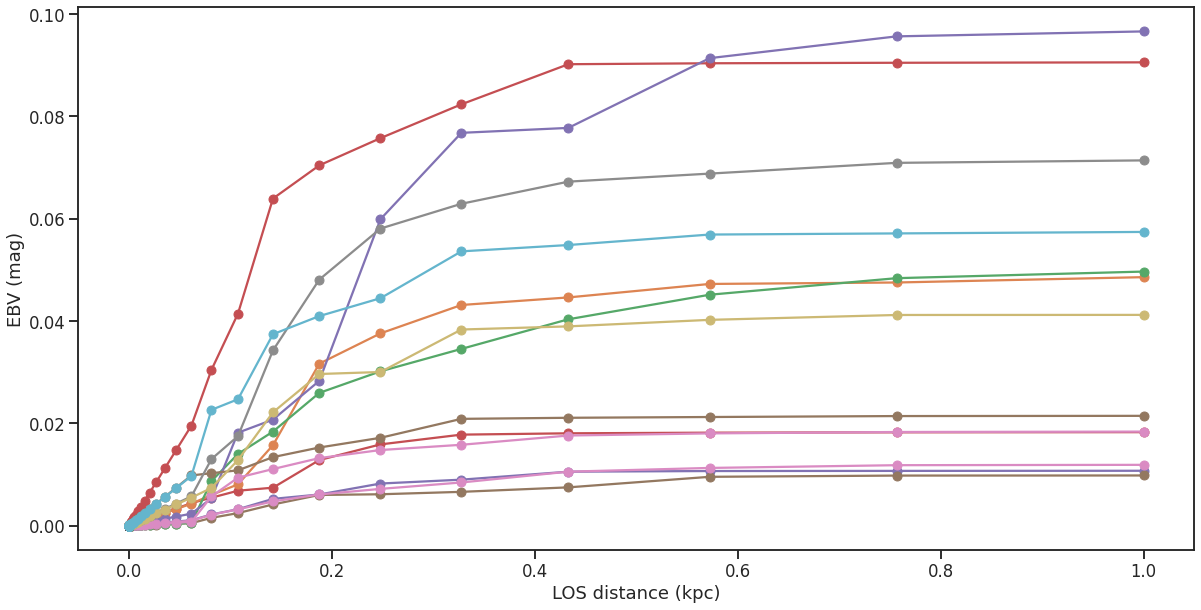

In [4]:
bst = BayestarWebQuery(version="bayestar2015")
dist = np.logspace(np.log10(1e-12), np.log10(1), 100)
# plt.plot(dist, np.zeros_like(dist), "ok")

plt.figure(figsize=(20,10))
for idx, row in darks.to_pandas().head(20).iterrows():
    ebv = bst(SkyCoord(
        ra=row["ra"]*u.deg,
        dec=row["dec"]*u.deg,
        distance=dist*u.kpc,
    ), mode="median")

    plt.plot(dist, ebv, "o-")

plt.xlabel("LOS distance (kpc)")
plt.ylabel("EBV (mag)")
# use SK law to estimate a first order Halpha

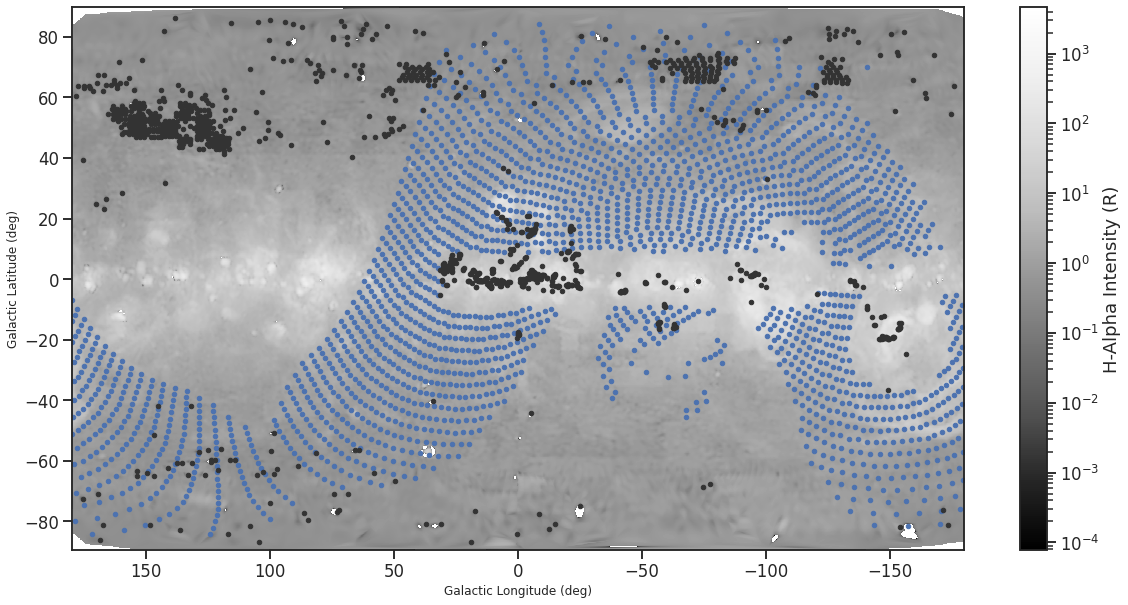

In [5]:
# u.add_enabled_units({"DEG": u.deg})

# Load Survey
wham = SkySurvey()
# Quick Sky Map
fig = wham.intensity_map(smooth=True, colorbar=True, cmap="Greys_r", vmin=None, vmax=None, fig=plt.figure(figsize=(20,10)))
ax = plt.gca()

# dark_coords = SkyCoord(darks["ra"], darks["dec"], unit="deg")
# dark_l = dark_coords.galactic.l.wrap_at(180*u.deg)
# dark_b = dark_coords.galactic.b.wrap_at(90*u.deg)

new_darks_coords = SkyCoord(new_darks["ra"], new_darks["dec"], unit="deg")
new_dark_l = new_darks_coords.galactic.l.wrap_at(180*u.deg)
new_dark_b = new_darks_coords.galactic.b.wrap_at(90*u.deg)

ori_coords = SkyCoord(survey["ra"]*u.deg, survey["dec"]*u.deg)
ori_l = ori_coords.galactic.l.wrap_at(180*u.deg).value
ori_b = ori_coords.galactic.b.wrap_at(90*u.deg).value

ax.plot(ori_l, ori_b, ".b")
# ax.plot(dark_l, dark_b, ".", color="0.3")
ax.plot(new_dark_l, new_dark_b, ".", color="0.2")

# survey

In [6]:
# TODO: pass the JD to use the correct ephemeris
# cross-match science targets with dark patches
# in order to get the JD for each dark patch

REWRITE = False

cache_dark_paths = f"_data-sky/darks-{TARGET_SURVEY.lower()}.pk"

if REWRITE or not os.path.isfile(cache_dark_paths):
    calculator = sh.shadow_calc()
    loc = EarthLocation(
        lat=calculator.observatory_topo.latitude.degrees*u.deg,
        lon=calculator.observatory_topo.longitude.degrees*u.deg,
        height=calculator.observatory_elevation
    )

    sci_ids, sky_ids, dists, shadow_heights, airmasses, alt, az, lst, lunation, moon_dist = [], [], [], [], [], [], [], [], [], []
    for obs in tqdm(survey, desc="matching science to sky fields"):
        for dark in new_darks:
            # TODO: implement science id in this loop
            # TODO: implement filtering sky observations by:
            #   - visibility
            #   - shadow heights
            #   - moon distance
            #   - airmass

            # update ephemeris in calculator
            calculator.update_time(jd=obs["JD"])
            calculator.set_coordinates(dark["ra"], dark["dec"])

            sk = SkyCoord(ra=dark["ra"], dec=dark["dec"], unit="deg")
            pos = Star(ra_hours=sk.ra.to(u.hourangle), dec_degrees=sk.dec.to(u.deg))

            ts = load.timescale()
            t = ts.tt_jd(obs["JD"])
            visible_at = risings_and_settings(calculator.eph, pos, calculator.observatory_topo)
            if not visible_at(t): continue

            time = Time(obs["JD"], format="jd", location=loc)
            eh = sk.transform_to(AltAz(obstime=time, location=loc))
            airmass = eh.secz.value
            if airmass < survey["airmass"].min() or airmass > survey["airmass"].max(): continue

            mdist = moon_separation(obs["JD"], calculator.eph, ra=sk.ra.to(u.hourangle), dec=sk.dec.to(u.deg))
            if mdist < survey["moon_dist"].min(): continue

            shadow_height = calculator.get_heights()[0]
            if shadow_height < survey["shadow_height"].min(): continue

            sci_ids.append(obs["i"])
            sky_ids.append(dark["i"])
            dists.append(distance(obs['ra'], obs['dec'], dark['ra'], dark['dec']))
            moon_dist.append(mdist)
            lunation.append(moon_phase(obs["JD"], calculator.eph))
            alt.append(eh.alt.value)
            az.append(eh.az.value)
            airmasses.append(airmass)
            lst.append(time.sidereal_time("mean").value)
            shadow_heights.append(shadow_height)

    sci_ids = np.asarray(sci_ids)
    sky_ids = np.asarray(sky_ids)
    dists = np.asarray(dists)
    shadow_heights = np.asarray(shadow_heights)
    alt = np.asarray(alt)
    az = np.asarray(az)
    lst = np.asarray(lst)
    airmasses = np.asarray(airmasses)
    lunation = np.asarray(lunation)
    moon_dist = np.asarray(moon_dist)

    pickle.dump((sci_ids, sky_ids, dists, shadow_heights, alt, az, lst, airmasses, lunation, moon_dist), open(cache_dark_paths, "wb"))
else:
    sci_ids, sky_ids, dists, shadow_heights, alt, az, lst, airmasses, lunation, moon_dist = pickle.load(open(cache_dark_paths, "rb"))

In [7]:
sky_sci_table = Table()
sky_sci_table.add_column(sci_ids, name="sci_id")
sky_sci_table.add_column(sky_ids, name="sky_id")
sky_sci_table.add_column(dists, name="distance")
sky_sci_table.add_column(shadow_heights, name="shadow_heights")
sky_sci_table.add_column(alt, name="alt")
sky_sci_table.add_column(az, name="az")
sky_sci_table.add_column(lst, name="lst")
sky_sci_table.add_column(airmasses, name="airmass")
sky_sci_table.add_column(lunation, name="lunation")
sky_sci_table.add_column(moon_dist, name="moon_dist")
# sky_sci_table.add_column((lst*u.hourangle - np.tile(new_darks["ra"], reps=len(survey))*u.deg).value, name="ha")
sky_sci_table

sci_id,sky_id,distance,shadow_heights,alt,az,lst,airmass,lunation,moon_dist
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64
85,55,59.957831947428026,1029.7233006100598,63.671781475558866,13.631581552152252,4.731701879765396,1.1157375710330883,0.998214199901338,89.75243305496424
85,56,53.178048232764134,1076.846576649291,62.88810560566202,29.648282898728187,4.731701879765396,1.123446281691621,0.998214199901338,88.1135252564924
85,57,52.916593478984716,1071.556109876758,63.222580694618536,30.13413500252762,4.731701879765396,1.1201175490163804,0.998214199901338,88.10435153066419
85,58,52.95981243460313,1072.998360568522,63.135283838041445,30.061849050866396,4.731701879765396,1.12098075070201,0.998214199901338,88.10151908699189
85,59,52.989165293476624,1076.0235328565545,62.96249063272124,30.04526060079987,4.731701879765396,1.1227009741087126,0.998214199901338,88.08411887559703
85,60,51.912582985944375,1053.5832231950385,64.39677480307955,32.15216490112583,4.731701879765396,1.108883238103482,0.998214199901338,88.0541756480118
85,61,51.67515171498513,1049.7091409389297,64.65610090350599,32.66228396625189,4.731701879765396,1.106494753934371,0.998214199901338,88.0399268523739
85,62,51.59262327230292,1052.4851447557523,64.49739637007674,32.87920795647231,4.731701879765396,1.1079525597451998,0.998214199901338,88.00215673228254
85,63,51.381868764746685,1055.3561790765427,64.34657743290404,33.39003677636775,4.731701879765396,1.1093493929903728,0.998214199901338,87.93940503939653


In [8]:
# mask = np.abs(sky_sci_table["ha"]) <= 3.5
# mask &= sky_sci_table["airmass"] < 1.3
# mask &= (survey["shadow_height"].min() <= sky_sci_table["shadow_heights"]) & (sky_sci_table["shadow_heights"] <= survey["shadow_height"].max())


sky_sci_match = sky_sci_table#[mask]
sky_sci_match

sci_id,sky_id,distance,shadow_heights,alt,az,lst,airmass,lunation,moon_dist
int64,int64,float64,float64,float64,float64,float64,float64,float64,float64
85,55,59.957831947428026,1029.7233006100598,63.671781475558866,13.631581552152252,4.731701879765396,1.1157375710330883,0.998214199901338,89.75243305496424
85,56,53.178048232764134,1076.846576649291,62.88810560566202,29.648282898728187,4.731701879765396,1.123446281691621,0.998214199901338,88.1135252564924
85,57,52.916593478984716,1071.556109876758,63.222580694618536,30.13413500252762,4.731701879765396,1.1201175490163804,0.998214199901338,88.10435153066419
85,58,52.95981243460313,1072.998360568522,63.135283838041445,30.061849050866396,4.731701879765396,1.12098075070201,0.998214199901338,88.10151908699189
85,59,52.989165293476624,1076.0235328565545,62.96249063272124,30.04526060079987,4.731701879765396,1.1227009741087126,0.998214199901338,88.08411887559703
85,60,51.912582985944375,1053.5832231950385,64.39677480307955,32.15216490112583,4.731701879765396,1.108883238103482,0.998214199901338,88.0541756480118
85,61,51.67515171498513,1049.7091409389297,64.65610090350599,32.66228396625189,4.731701879765396,1.106494753934371,0.998214199901338,88.0399268523739
85,62,51.59262327230292,1052.4851447557523,64.49739637007674,32.87920795647231,4.731701879765396,1.1079525597451998,0.998214199901338,88.00215673228254
85,63,51.381868764746685,1055.3561790765427,64.34657743290404,33.39003677636775,4.731701879765396,1.1093493929903728,0.998214199901338,87.93940503939653


In [9]:
REWRITE = False
cache_sci_path = f"_data-sky/sky_sci-{TARGET_SURVEY.lower()}.pk"

if REWRITE or not os.path.isfile(cache_sci_path):
    if "sky_sci" not in dir(): sky_sci = {}
    for row in tqdm(survey, total=len(survey), desc="simulating sky for science pointings"):
        date = Time(row["JD"], format="jd")# - timedelta(days=5*365)

        if row["i"] in sky_sci.keys(): continue

        _, sky_sci[row["i"]] = sky.get_sky_model(
            wmin=365, wmax=1040, wres=3000,
            observatory="lasilla", date=date.strftime("%Y-%m-%dT%H:%M:%S"),
            ra=row["ra"], dec=row["dec"],
            return_pars=False
        )
    
    pickle.dump(sky_sci, open(cache_sci_path, "wb"))
else:
    sky_sci = pickle.load(open(cache_sci_path, "rb"))

In [10]:
sci_i = np.unique(sky_sci_match["sci_id"])[0]
print(f"target science: {sci_i}")

darks_i = sky_sci_match[sky_sci_match["sci_id"]==sci_i]["sky_id"].value
print(f"sky pointing candidates: {len(darks_i)}")

target science: 85
sky pointing candidates: 53


In [11]:
# sky_sci = {}
# row = survey[survey["i"]==sci_i][0]

# date = Time(row["JD"], format="jd")# - timedelta(days=5*365)

# _, sky_sci[row["i"]] = sky.get_sky_model(
#     wmin=365, wmax=1040, wres=3000,
#     observatory="lasilla", date=date.strftime("%Y-%m-%dT%H:%M:%S"),
#     ra=row["ra"], dec=row["dec"],
#     return_pars=False
# )

In [12]:
REWRITE = False
cache_sky_path = f"_data-sky/sky_sky-{TARGET_SURVEY.lower()}-{sci_i}.pk"

if REWRITE or not os.path.isfile(cache_sky_path):

    sky_sky = {}
    for idx in tqdm(darks_i, total=len(darks_i), desc="simulating sky for sky pointings"):
        date = Time(lvm["JD"][sci_i], format="jd")# - timedelta(days=5*365)

        try:
            _, sky_sky[idx] = sky.get_sky_model(
                wmin=365, wmax=1040, wres=3000,
                observatory="lasilla", date=date.strftime("%Y-%m-%dT%H:%M:%S"),
                ra=new_darks["ra"][idx], dec=new_darks["dec"][idx],
                return_pars=False
            )
        except:
            continue
    
    pickle.dump(sky_sky, open(cache_sky_path, "wb"))
else:
    sky_sky = pickle.load(open(cache_sky_path, "rb"))

In [13]:
sky_sky_coords = SkyCoord(ra=new_darks[darks_i]["ra"]*u.deg, dec=new_darks[darks_i]["dec"]*u.deg)
sky_sky_l, sky_sky_b = sky_sky_coords.galactic.l.wrap_at(180*u.deg), sky_sky_coords.galactic.b.wrap_at(90*u.deg)

Text(0, 0.5, 'radiance (photons/s/m/arcsec)')

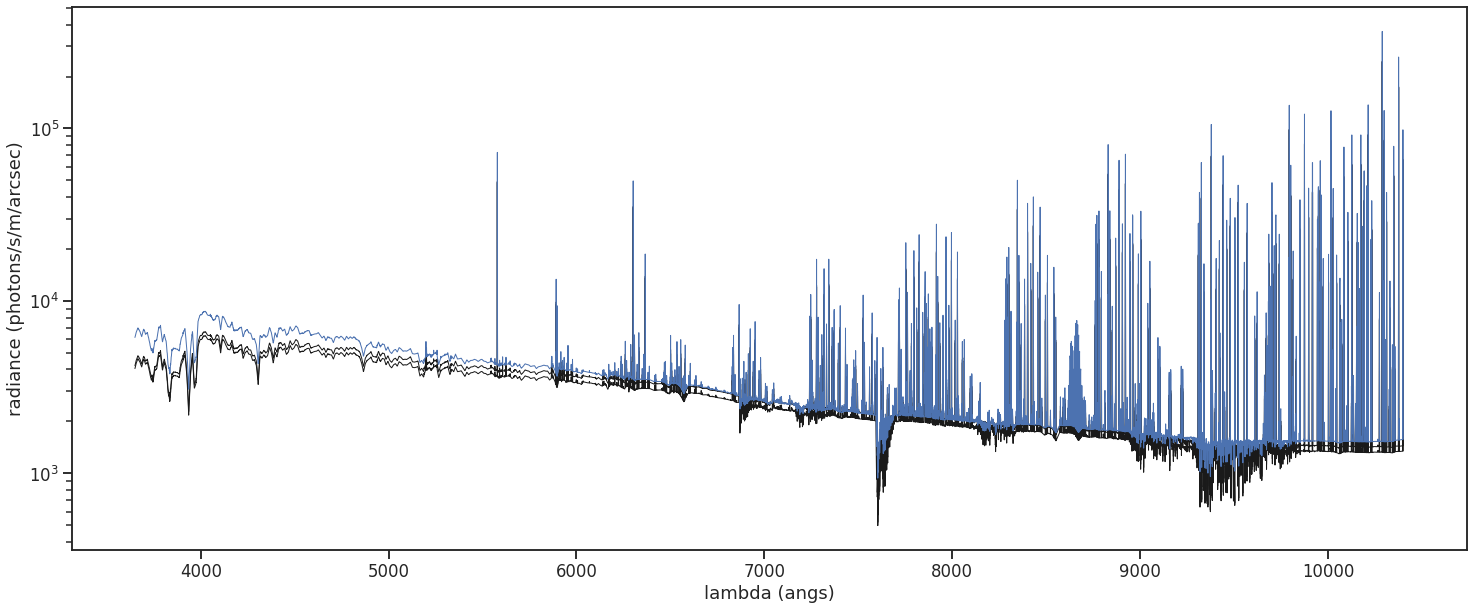

In [14]:
fig, ax = plt.subplots(figsize=(25,10))

ax.semilogy(sky_sky[darks_i[0]]["lam"], sky_sky[darks_i[0]]["flux"]/sky_sky[darks_i[0]]["trans"], color="k", lw=1)
ax.semilogy(sky_sky[darks_i[1]]["lam"], sky_sky[darks_i[1]]["flux"]/sky_sky[darks_i[1]]["trans"], color="k", lw=1)
ax.semilogy(sky_sci[sci_i]["lam"], sky_sci[sci_i]["flux"]/sky_sci[sci_i]["trans"], color="b", lw=1)
ax.set_xlabel(r"lambda (angs)")
ax.set_ylabel(r"radiance (photons/s/m/arcsec)")

In [68]:
sky_cont_path = "_data-sky/sky-cont.rss.fits"
if not os.path.isfile(sky_cont_path):
    sky_cont = []
    for sky_table in sky_sci.values():
        sky_cont.append(sky_table["flux"])

    sky_wl = sky_table["lam"].value
    sky_cont = np.asarray(sky_cont)

    header = fits.Header()
    header["CDELT"] = np.diff(sky_wl)[0]
    header["CRPIX"] = 1.0
    header["CRVAL"] = sky_wl[0]
    hdu = fits.PrimaryHDU(data=sky_cont, header=header)
    hdu.writeto(sky_cont_path, overwrite=True)

Text(0, 0.5, 'flux_sky / flux_sci')

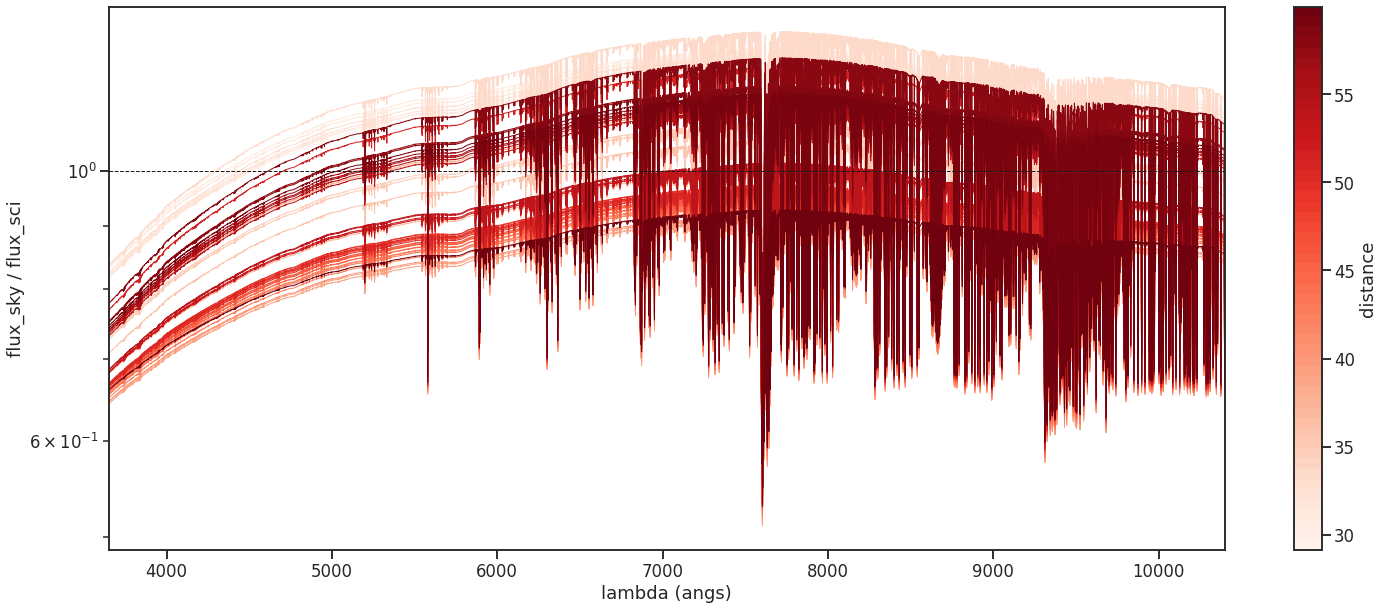

In [15]:

fig, ax = plt.subplots(figsize=(25,10))

# TODO: sort target parameter in ascending order
# to be able to match in color scale
target_par_name = "distance"
target_par = sky_sci_match[sky_sci_match["sci_id"]==sci_i][target_par_name]
# target_par = (sky_sci_match[sky_sci_match["sci_id"]==sci_i]["lst"]*u.hourangle - sky_sky_coords.ra.to(u.hourangle)).value
isort = np.argsort(target_par)

sky_sci_ids = np.asarray(list(sky_sky.keys()))

target_par = target_par[isort]
sky_sci_ids = sky_sci_ids[isort]

colors = sns.color_palette("Reds", target_par.size)
norm = plt.cm.colors.Normalize(target_par.min(), target_par.max())
# norm = plt.cm.colors.CenteredNorm()
cmap = plt.cm.colors.LinearSegmentedColormap.from_list("", colors, target_par.size)

residuals = []
for i, idx in enumerate(sky_sci_ids):
    joint_residuals = (sky_sky[idx]["flux"]/sky_sky[idx]["trans"]/(sky_sci[sci_i]["flux"]/sky_sci[sci_i]["trans"]))# / sky_sky[idx]["flux"]
    ax.semilogy(sky_sky[idx]["lam"], joint_residuals, color=colors[i], lw=1, alpha=1)

    residuals.append(joint_residuals.value.tolist())

ax.axhline(1, ls="--", lw=1, color="k")

cb = plt.colorbar(plt.cm.ScalarMappable(norm,cmap))
cb.set_label(target_par_name)

ax.set_xlim(sky_sky[idx]["lam"].min(), sky_sky[idx]["lam"].max())
# ax.set_ylim(-0.7, 0.7)
ax.set_xlabel(r"lambda (angs)")
ax.set_ylabel(r"flux_sky / flux_sci")

In [16]:
# run simulations for sky module as close as possible to the DRP (actual sky module)
# transform simulations to counts
# feed them to the sky module and quantify the effects of interpolation and variability effects
# 